In [1]:
import random as r
import json

from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.ticker as mtick
import matplotlib as mpl

from architecture.NormalizedMeanSquaredError import NormalizedMeanSquaredError as NMSE
from architecture.NormalizedMeanSquaredError import NormalizedMeanSquaredError2D as NMSE2

parameters = {'axes.labelsize': 16,
              'axes.titlesize': 18,
              'legend.fontsize': 13,
              'xtick.labelsize': 16,
              'ytick.labelsize': 16,
              'figure.figsize': (12, 8),
              'figure.titlesize': 18,
              #'font.family': 'serif',
              'font.serif': 'Computer Modern Roman',
             }
plt.rcParams.update(parameters)
plt.rc('text', usetex=True)

In [2]:
# Set data file locations
data_file_prefix = './data/S3-NLP'
expt_name = "S3-NLP-Expt1-L200-a"

In [3]:
def load_data(data_file_prefix):
    # Step 1. Load in the data
    train_u = np.load("{}_train1_u.npy".format(data_file_prefix)).astype(np.float32)
    train_f = np.load("{}_train1_f.npy".format(data_file_prefix)).astype(np.float32)
    val_u = np.load("{}_val_u.npy".format(data_file_prefix)).astype(np.float32)
    val_f = np.load("{}_val_f.npy".format(data_file_prefix)).astype(np.float32)
    test_u1 = np.load("{}_test1_u.npy".format(data_file_prefix)).astype(np.float32)
    test_f1 = np.load("{}_test1_f.npy".format(data_file_prefix)).astype(np.float32)
    test_u = np.load("{}_test2_u.npy".format(data_file_prefix)).astype(np.float32)
    test_f = np.load("{}_test2_f.npy".format(data_file_prefix)).astype(np.float32)

    train_data = [train_u, train_f]
    val_data = [val_u,   val_f]
    test1_data = [test_u1, test_f1]
    test2_data = [test_u,  test_f]

    return train_data, val_data, test1_data, test2_data
    
def organize_data(data):
    return [{'x': [u, f], 
                 'y': [u, f, f, u]} \
                for (u,f) in data]

def plot_predict_vs_true(i, pred_u, pred_f, u, f, fig, ax1, ax2):
    
    # Grab the 'true' value
    true_u = u[i,:,:]
    true_F = f[i,:,:]

    # And predicted value
    predict_u = pred_u[i,:,:]
    predict_F = pred_f[i,:,:]

    # create a space vector
    x = np.linspace(0,2*np.pi, predict_u.shape[0])
    X, Y = np.meshgrid(x,x)
    
    # Create the figures
    ax = ax1[0]
    cont = ax.contourf(X, Y, true_u, 100)
    fig.colorbar(cont, ax=ax)
    ax.set_title(r'True $u(x)$')

    ax = ax2[0]
    cont = ax.contourf(X, Y, true_F, 100)
    fig.colorbar(cont, ax=ax)
    ax.set_title(r'True $F(x)$')
    
    ax = ax1[1]
    cont = ax.contourf(X, Y, predict_u, 100)
    fig.colorbar(cont, ax=ax)
    ax.set_title(r'Predicted $u(x)$')

    ax = ax2[1]
    cont = ax.contourf(X, Y, predict_F, 100)
    fig.colorbar(cont, ax=ax)
    ax.set_title(r'Predicted $F(x)$')
    
    ax = ax1[2]
    cont = ax.contourf(X, Y, true_u-predict_u, 100)
    fig.colorbar(cont, ax=ax)
    ax.set_title('Difference')

    ax = ax2[2]
    cont = ax.contourf(X, Y, true_F-predict_F, 100)
    fig.colorbar(cont, ax=ax)
    ax.set_title('Difference')

In [4]:
def generate_compare_plot(full_model, u, F, expt_name, data_name, sup_title):
    modes = ['Best', 'Mean', 'Worst']

    for j in range(3):
        mode = modes[j]   
        
        fig, [ax1, ax2] = plt.subplots(2,3, sharex=True, sharey=True, figsize=(12,8))
        i = find_sample(u, F, full_model, mode=mode)
        _, _, F_pred, u_pred = full_model.predict((u,F))

        fig.suptitle(sup_title + ": " + mode + " Case")
        plot_predict_vs_true(i, u_pred, F_pred, u, F, fig, ax1, ax2)
        
        plt.savefig("figures/{}-{}-{}pred.png".format(expt_name, mode, data_name), transparent=True)

In [5]:
def rel_mse(pred, true, den_nonzero=1e-5):
    num = np.mean(np.mean(np.square(pred-true), axis=-1), axis=-1)
    den = np.mean(np.mean(np.square(true), axis=-1), axis=-1)
    den += den_nonzero
    return np.divide(num, den) 
    
    
def find_sample(u,f, full_model, mode='worst'):
    _, _, pred_f, pred_u = full_model.predict(x=[u, f])

    f_scores = rel_mse(pred_f, f)
    u_scores = rel_mse(pred_u, u)
    
    score = np.abs(f_scores) + np.abs(u_scores)
    #score = np.abs(u_scores)
    mean = np.mean(score)
    
    if mode.lower() == 'worst':
        idc = np.argmax(score)
    elif mode.lower() == 'best':
        idc = np.argmin(score)
        print(idc)
    elif mode.lower() == 'mean':
        idc = np.argmin((score-mean)**2)
    else:
        print('{} mode not supported.'.format(mode))
        idc = np.argmin(score)
        
    return idc

def compute_losses(full_model, x, y):
    predicted_ys = full_model.predict(x=x)
    data = []
    for (pred_y, true_y) in zip(predicted_ys, y):
        data.append(rel_mse(pred_y, true_y, 1e-5))
    return data

In [6]:
## Load the best model
save_prefix = 'results/{}/'.format(expt_name)
full_model = keras.models.load_model(save_prefix + "final_model", 
                                     custom_objects={"NormalizedMeanSquaredError2D": NMSE2})

In [7]:
# Load the data
train_data, val_data, test1_data, test2_data = load_data(data_file_prefix)

# Organize the data
datasets = organize_data([train_data, val_data, test1_data, test2_data])

In [8]:
# Score the different datasets
for dset, dtype in zip(datasets, ['Train', 'Validation', 'Test 1', 'Test 2']):
    losses = full_model.evaluate(x=dset['x'], y=dset['y'], batch_size=64, return_dict=True, verbose=0)
    print("LOSSES for {}:".format(dtype))
    print([loss for loss in losses])
    for loss in losses:
        print(losses[loss], end=", ")
    print("\n")

LOSSES for Train:
['loss', 'output_1_loss', 'output_2_loss', 'output_3_loss', 'output_4_loss']
0.0006605386734008789, 6.540472531924024e-05, 0.00010811401443788782, 0.0001737428392516449, 9.102906187763438e-05, 

LOSSES for Validation:
['loss', 'output_1_loss', 'output_2_loss', 'output_3_loss', 'output_4_loss']
0.001166007248684764, 8.339615305885673e-05, 0.00015306140994653106, 0.0005818646168336272, 0.00012543716002255678, 

LOSSES for Test 1:
['loss', 'output_1_loss', 'output_2_loss', 'output_3_loss', 'output_4_loss']
0.0010861321352422237, 7.674529479118064e-05, 0.00014461606042459607, 0.0005269877729006112, 0.00011553515651030466, 

LOSSES for Test 2:
['loss', 'output_1_loss', 'output_2_loss', 'output_3_loss', 'output_4_loss']
0.08600173890590668, 0.003129786578938365, 0.009553038515150547, 0.057091210037469864, 0.016005435958504677, 



In [9]:
# Print out the optimizer learning rate:
print("\nLEARNING RATE:")
lr = full_model.optimizer.get_config()['learning_rate']
print(lr)


LEARNING RATE:
0.0004163638805039227


2360


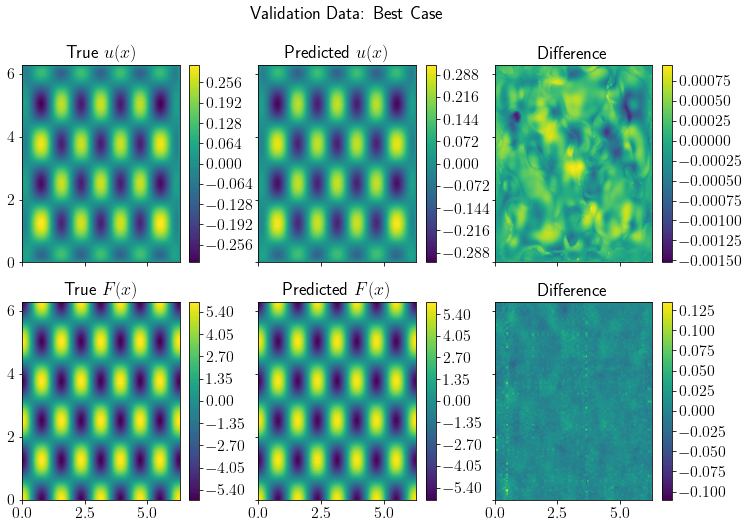

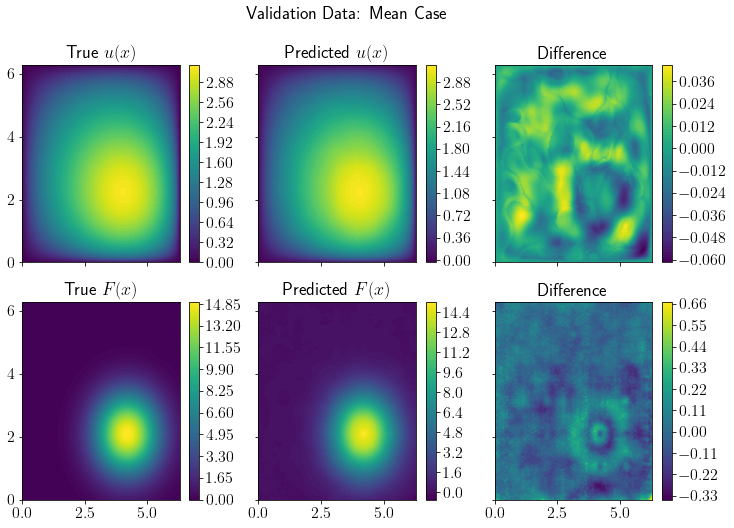

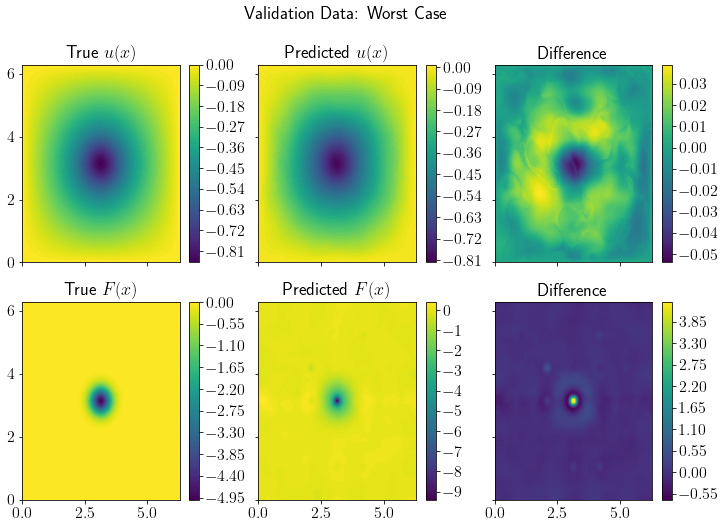

In [10]:
generate_compare_plot(full_model, *val_data, expt_name, 'val', 'Validation Data')

1245


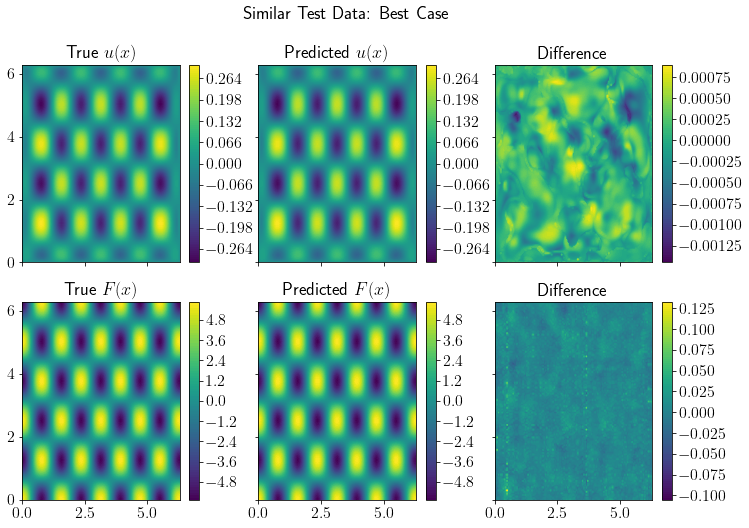

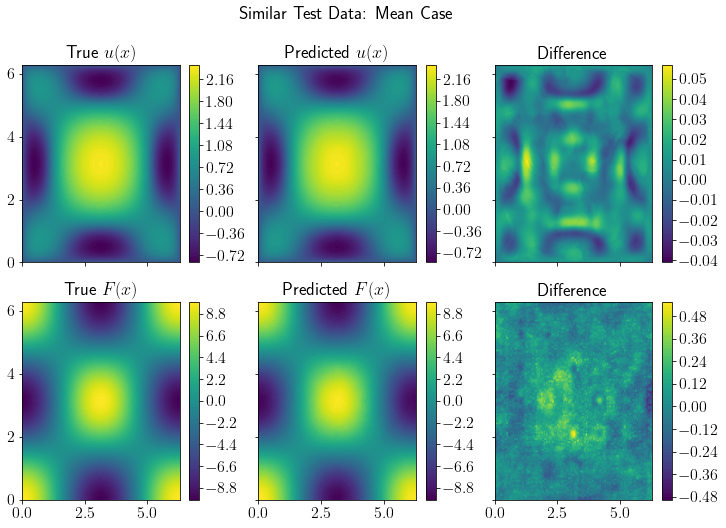

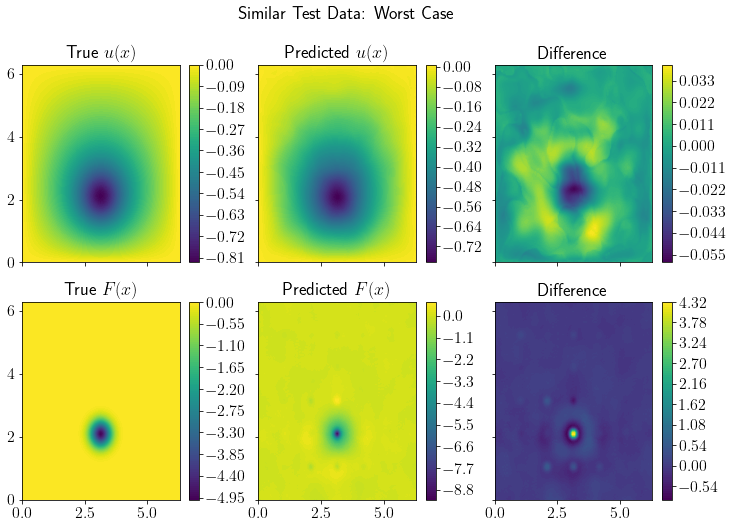

In [11]:
generate_compare_plot(full_model, *test1_data, expt_name, 'test1', 'Similar Test Data')

482


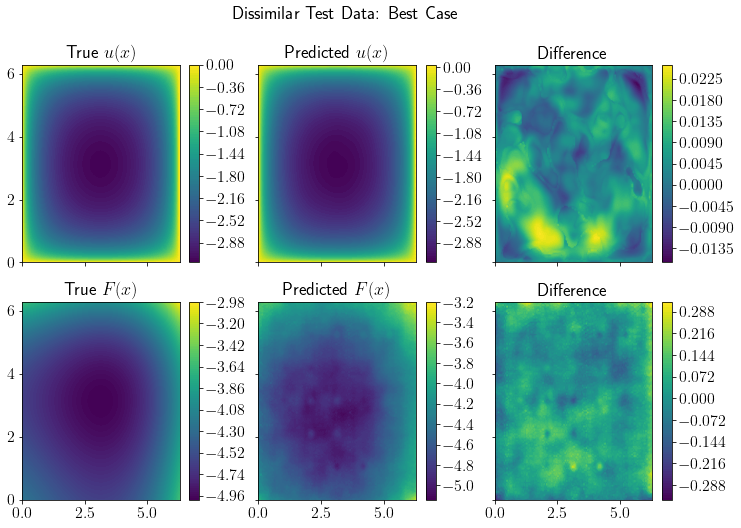

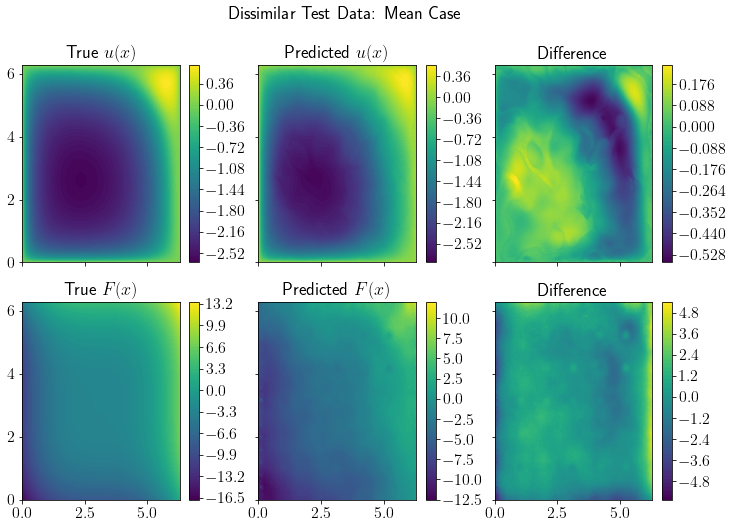

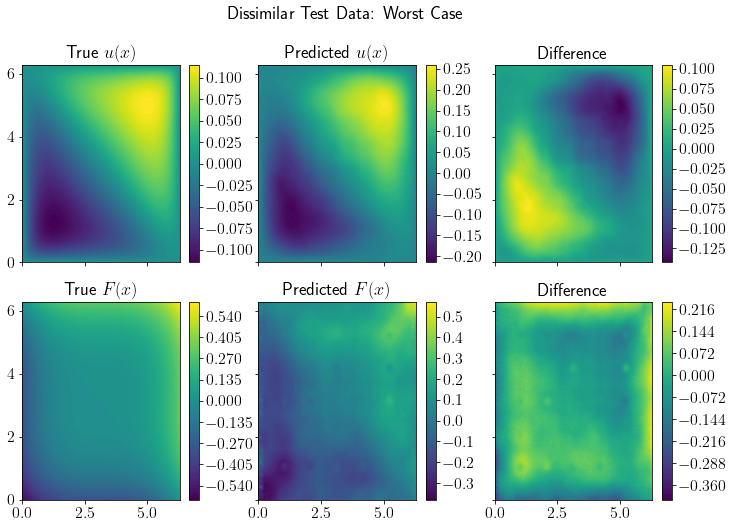

In [12]:
generate_compare_plot(full_model, *test2_data, expt_name, 'test2', 'Dissimilar Test Data')

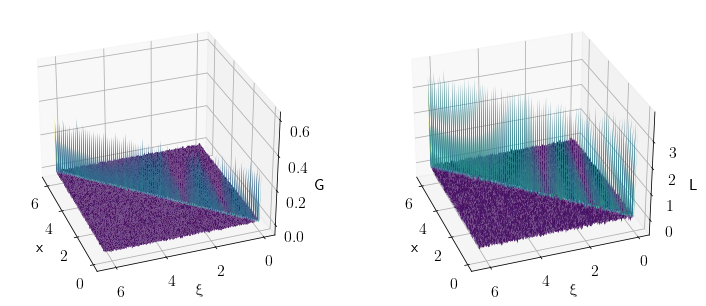

In [13]:
utm = tf.linalg.band_part(full_model.Operator, 0, -1, name="L_upper")
L = tf.multiply(0.5, utm+tf.transpose(utm), name="L")
G = np.linalg.inv(L)
x = np.linspace(0,2*np.pi, L.shape[0])
X,XI = np.meshgrid(x,x)

surf_opts = dict(rcount=128, ccount=128, antialiased=True, cmap='viridis')

fig = plt.figure(figsize=(10,4))
ax = plt.axes((0, 0, 0.48, 1), projection='3d')
ax.plot_surface(X, XI, G, **surf_opts)
ax.set_xlabel("x")
ax.set_ylabel(r'$\xi$')
ax.set_zlabel('G')
ax.view_init(30,160)


ax = plt.axes((0.52, 0, 0.48, 1), projection='3d')
ax.plot_surface(X, XI, L, **surf_opts)
ax.set_xlabel("x")
ax.set_ylabel(r'$\xi$')
ax.set_zlabel('L')
ax.view_init(30,160)

plt.savefig("figures/{}-L_and_G.png".format(expt_name), transparent=True)

plt.show()

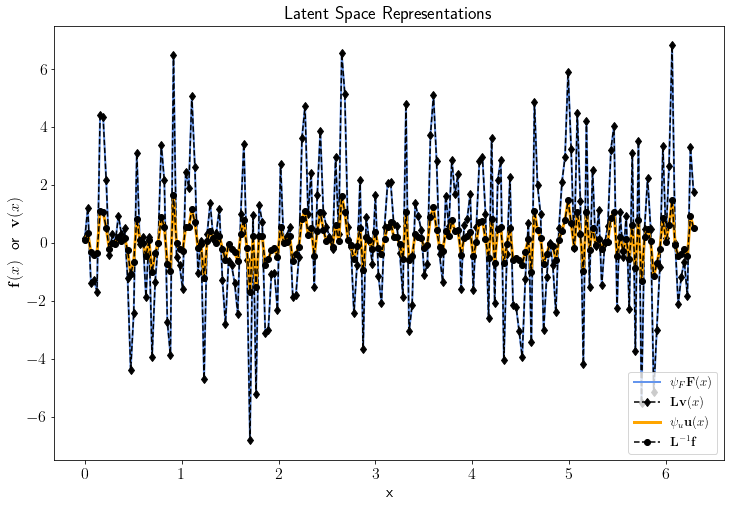

In [14]:
# Set up the data for latent space:
#i = 14

u_enc = full_model.layers[0]
F_enc = full_model.layers[2]

u, F = train_data
i = find_sample(u, F, full_model, mode='Mean')

sample_u = u[i:i+1,:]
sample_F = F[i:i+1,:]

v = tf.matmul(u_enc(sample_u), full_model.u_Reduce)
f = tf.matmul(F_enc(sample_F), full_model.F_Reduce)

Lv = tf.matmul(v, L)
Linvf = tf.matmul(f, G)


# Some plotting options
aec_line = dict(color='orange', lw=3)
cross_line = dict(color='k', linestyle='--', marker='o')
aec_line2 = dict(color='cornflowerblue', lw=2)
cross_line2 = dict(color='k', linestyle='--', marker='d')

# And now plot it!
fig = plt.figure()

plt.title("Latent Space Representations")

plt.plot(x, f.numpy().flatten(), **aec_line2, label=r'$\mathbf{\psi}_F \mathbf{F}(x)$')
plt.plot(x, Lv.numpy().flatten(), **cross_line2, label=r'$\mathbf{L v}(x)$')
plt.plot(x, v.numpy().flatten(), **aec_line, label=r'$\mathbf{\psi}_u \mathbf{u}(x)$')
plt.plot(x, Linvf.numpy().flatten(), **cross_line, label=r'$\mathbf{L}^{-1}\mathbf{f}$')

#plt.legend(loc='center', bbox_to_anchor=(1.1,0.5))
plt.legend(loc='lower right')
plt.ylabel(r"$\mathbf{f}(x)\;$ or $\;\mathbf{v}(x)$")
plt.xlabel("x")

plt.savefig("figures/{}-latentspace.png".format(expt_name), transparent=True)

plt.show()

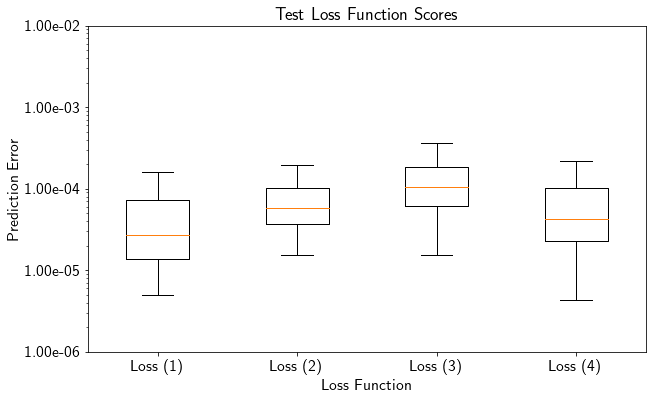

In [15]:
# Select a dataset to generate the plot from:
plot_for = 'Test'
dsets = {'Training': 0, 'Validation': 1, 'Test': 2, 'Polynomials': 3}
dset = datasets[dsets[plot_for]]

data = compute_losses(full_model, dset['x'], dset['y'])
labels = ["Loss (1)", "Loss (2)",  "Loss (3)", "Loss (4)"]

#print(len(data), len(labels))

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_title(r'{} Loss Function Scores'.format(plot_for))
ax.set_ylabel("Prediction Error")
ax.set_xlabel("Loss Function")
ax.boxplot(data, labels=labels, showfliers=False)
#ax.ticklabel_format(axis='y', style='sci')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.ylim([1e-6, 1e-2])

plt.savefig("figures/" + expt_name + "-{}-boxplot.png".format(plot_for))

plt.show()

In [16]:
results_path = save_prefix + "initial_pool_results.json"
init_results = json.load(open(results_path))

results_path = save_prefix + "final_model_history.json"
final_results = json.load(open(results_path))

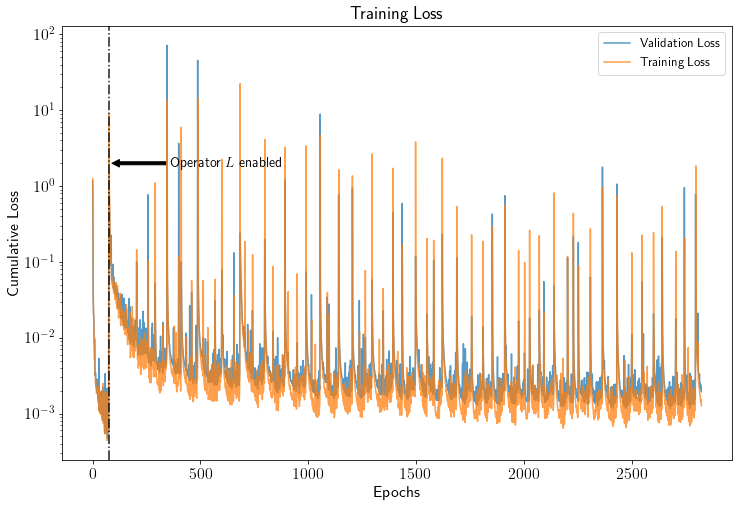

In [17]:
from matplotlib.patches import FancyArrowPatch

best_model_idc = np.argmin(init_results['best_loss'])

train_loss = init_results['aec_hist'][best_model_idc]['loss'] + init_results['full_hist'][best_model_idc]['loss'] + final_results['loss']
val_loss = init_results['aec_hist'][best_model_idc]['val_loss'] + init_results['full_hist'][best_model_idc]['val_loss'] + final_results['val_loss']



plt.figure()

plt.semilogy(val_loss, label="Validation Loss", alpha=0.75)
plt.semilogy(train_loss, label="Training Loss", alpha=0.75)

plt.axvline(75, linestyle='-.', color='k', alpha=0.9)
#plt.axvline(325)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Cumulative Loss")
plt.legend(loc='upper right')
ax = plt.gca()
arrow = FancyArrowPatch((350,2), (80,2), fc='k', arrowstyle='Simple', mutation_scale=15)
ax.add_patch(arrow)
ax.annotate(r"Operator $L$ enabled", xy=(360,1.8), fontsize=14)

plt.savefig("figures/{}-trainingloss.png".format(expt_name), transparent=True)

plt.show()